In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import seaborn as sns
from mpfit import mpfit

sns.set(style="ticks")
sns.set_style({'axes.linewidth': 1, 'grid.color': \
               'black',"xtick.direction": "in","ytick.direction": "in"})

Define gloabl parameters and data

In [37]:

class All:
    Path = '/Users/inchanji/Research/galsim/practice/ctr_set/github/'
    inputmagsfile = 'input_mags.txt'
    sexdatafile   = 'measurements.sexcat'        
    
    imgfilename   = 'fieldimage.fits'
    segfilename   = 'segmap.fits'    

    
    MaxPos = 7999
    NCOMBINE = 20
    m0       = 32.73
    Modellist = ['mygalR24_avg.fits', 'mygalR25_avg.fits', \
                 'mygalR26_avg.fits','mygalR27_avg.fits',\
                 'mygalR28_avg.fits','mygalR29_avg.fits']
    Rmaglist = [ 26.1, 26.3,  26.5,  26.7,  26.9,  27.1,\
                27.3,  27.5,  27.7,  27.9,  28.1,  28.3,  28.5,\
                28.7, 28.9]
    Ngallist = [ 4746, 9141, 13744, 17468, 21147, 25427,\
                30570, 36753, 44187, 53125, 63870, 76789, 92320,\
                110994, 133444]

    HistFac  = (80./8000.)**2.
    Rmaglist = np.array(Rmaglist); Ngallist = np.array(Ngallist,dtype='float')
    Ngallist *=  HistFac    

    HistUGalsPix0 = []; 
    for i in range(len(Rmaglist)):
        Rmag = int(round(Rmaglist[i]))
        filename = 'mygalR'+str(Rmag)+'_avg.fits'
        hdu = fits.open(Path+filename)
        prof0 = hdu[0].data.ravel() 

        Ftot = 10.**((m0-Rmaglist[i])/2.5)
        prof0 = prof0[np.argsort(prof0)[::-1]]
        prof0 *= Ftot            
        prof0 = prof0[prof0 > 0.81] # 30 mag /arcsec^2
        for j in range(int(Ngallist[i])):
            HistUGalsPix0 += list(prof0)
    HistUGalsPix0 = np.array(HistUGalsPix0)  
    
    
class Map:
    hdu  = fits.open(All.Path + All.imgfilename)
    Img  = hdu[0].data.copy() # image
    hdu = fits.open(All.Path + All.segfilename)
    Seg = hdu[0].data.copy() # seg map
    del hdu

Define subroutines for sky estimation

In [3]:
def GalNum(R):
    return 10.**(0.4*R - 6.4347)

def return_mask_fac(totalmag):
    if totalmag < 20.:  fac = 15
    elif totalmag < 21: fac = 10
    elif totalmag < 22: fac = 8
    elif totalmag < 23: fac = 6
    else:               fac = 4
    return fac


def grow_mask(MaskMap, fac = 2, val = 1):
    Ny, Nx = MaskMap.shape
    x = np.linspace(-1.*fac,1.*fac,fac*2+1)
    X,Y = np.meshgrid(x, x)
    Z   = X**2. + Y**2.
    Z[Z <= 1.*fac**2.] = np.nan; 
    MaskMap0 = np.zeros((Ny, Nx)) * 1.
    MaskMap0[:] = MaskMap[:]
    ind = np.where(MaskMap[:] == val)   

    MaskMap0[ind] = np.nan
    if np.sum(ind) > 0:
        i_row = ind[0]; i_col = ind[1]
        N = len(i_col)   
        for i in range(N):
            x = i_col[i]; y = i_row[i]
            x0 = x-fac; y0 = y-fac; x1 = x+fac; y1 = y+fac
            x00 = y00 = x11 = y11 = 0
            if x0 < 0: 
                x0 = 0; x00 = fac - x; 
            if y0 < 0: 
                y0 = 0; y00 = fac - y
            if y1 > Ny-1:
                y11 = y1 - Ny +1; y1 = Ny-1; 
            if x1 > Nx-1:
                x11 = x1 - Nx +1; x1 = Nx-1; 
            MaskMap0[y0:y1+1,x0:x1+1] += Z[y00:2*fac+1-y11,x00:2*fac+1-x11]
    MaskMap[np.isnan(MaskMap0)] = val
    del MaskMap0
    return MaskMap

def clipping3sig(data):
    data = data.ravel()
    mu  = np.mean(data)
    sig = np.std(data)
    ind0 = data > mu + 3. * sig
    while np.sum(ind0):
        ind  = np.where( data < mu + 3. * sig )[0]
        data = data[ind].copy()
        mu   = np.mean(data)
        sig  = np.std(data)
        ind0 = data > mu + 3. * sig
    return mu, sig

def est_sky_SEx(data, fac = 0.2):
    sky = np.median(data); sig = np.std(data); N0  = len(data);
    ind = np.where(np.abs(data-sky) < 3. * sig)[0]
    data = data[ind].copy()
    N   = len(data); sig_ori = np.std(data)
    N0  = N + 1 
    Crowd = False
    while N != N0:
        N0  = N; sky = np.median(data); sig = np.std(data);
        ind = np.where(np.abs(data-sky) < 3. * sig)[0]
        data = data[ind].copy()
        sig = np.std(data); N = len(ind);
    if np.abs(sig-sig_ori) / sig_ori > fac: Crowd = True        
    if Crowd: return 2.5 * np.median(data) - 1.5 * np.mean(data), sig, True
    else:     return np.mean(data), sig, False

def EBL(x, X, Y, binsize, sky, noise):
    y = np.zeros(len(x))
    for i in range(len(X)):
        sig = np.sqrt(noise**2. + 1. * X[i]**2. / All.NCOMBINE)    
        amp = Y[i] * binsize / np.sqrt(2. * np.pi) / sig 
        if i == 0:
            y = amp * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig)
        else:
            y += amp * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig)    
    return y

def gauss(x, p):
    return p[0] * np.exp( -(x-p[1])**2. / (2.*p[2]**2.) )

def myskyfit(p, fjac = None, x = None, y = None, x2 = None, y2 = None, binsize= None):
    status  = 0        
    model   = gauss(x,p[:3]) + EBL(x, x2,y2,binsize,p[1], p[2]) * p[3]

    deviation = (y - model) / np.sqrt(y) 
    ind = y > 0.
    return [ status, deviation[ind] ] 

def skyfit( x = [], y = [],  x2 = [], y2 = [],param = [], binsize = 3.,Quiet = 1):
    nparam  = len(param)
    fa = {'x':x, 'y':y ,'x2':x2, 'y2':y2, 'binsize': binsize }
    par_info = [{'value': 0., 'fixed': 0, 'limited': [0, 0], 'limits' : [0., 0.], 'tied' : ''} \
                for i in range(nparam)]

    for i in range(nparam): 
        par_info[i]['value']      =  param[i]
        par_info[i]['limited']    =  [1, 1]

    par_info[0]['limits'] = [ param[0] * 1e-10      , param[0]  * 1.5    ]  # amplitude
    par_info[1]['limits'] = [ param[1] - param[2] , param[1] + param[2] ]  # mean +/- sigma
    if param[2] > 200.: par_info[2]['value'] = 100.
    par_info[2]['limits'] = [ 1.      , 200.    ]  # standard devidation
    par_info[3]['limits'] = [ param[3]*0.9999, param[3]*1.00001]

    m     =     mpfit( myskyfit, parinfo = par_info, functkw = fa, quiet = Quiet )
    return m.params, m.fnorm, m.perror


def estimate_sky(xc,yc,Re):
    dx = dy = int(Re*20.) 
    iterate = True 

    while iterate:
        x0 = xc - dx; x1 = xc + dx; y0 = yc - dy; y1 = yc + dy;
        if x0 < 0: x0 = 0 ; 
        if x1 > All.MaxPos: x1 = All.MaxPos;
        if y0 < 0: y0 = 0 ; 
        if y1 > All.MaxPos: y1 = All.MaxPos;
        img = Map.Img[y0:y1+1, x0:x1+1].copy()
        seg = Map.Seg[y0:y1+1, x0:x1+1].copy()

        Nmax = np.max(seg.ravel())
        for i in range(1, Nmax+1):
            if np.sum(seg.ravel() == i) == 0: continue
            flux = np.sum(img.ravel()[seg.ravel() == i])
            mag = All.m0 - 2.5*np.log10(flux)
            fac = return_mask_fac(mag) 
            seg = grow_mask(seg, fac, i)

        ind_not	 = np.logical_not(seg == 0) 
        seg[ind_not] = -1
        seg = grow_mask(seg, fac, -1)
        if (np.sum(seg != -1) > 4000) and ((x1 - x0 + 1  > 79) \
            or  (y1 - y0 + 1  > 79)): iterate = False
        else: 
            dx += 5; dy += 5;

    img[seg == -1] = np.nan
    data = img[np.isfinite(img)].copy().ravel()
    mu_SEx, sig_SEx, Crowd =  est_sky_SEx(data.copy())
    minval = np.max([mu_SEx - 3. * sig_SEx, -150]);   
    
    data = img[np.isfinite(img)].copy().ravel()
    mu_SEx, sig_SEx, Crowd =  est_sky_SEx(data.copy())
    minval = np.max([mu_SEx - 3. * sig_SEx, -150]);   
    binsize =  3.5 * np.std(data) *  len(data) **(-0.33333333) * 1. # Bin size by Scott rule
    maxval = mu_SEx + 3.* sig_SEx    
    maxval = minval + round((maxval-minval)/binsize) * binsize

    bins, edges = np.histogram(data, int((maxval - minval)/binsize), \
                               range = [minval,maxval])
    left, right = edges[:-1],edges[1:]
    x_hist = np.array([left,right],dtype = 'float').T.flatten(); 
    y_hist = np.array([bins,bins], dtype = 'float').T.flatten();    
    x = x_hist[::2] + 0.5 * (x_hist[1]-x_hist[0]); y = y_hist[::2];   


    bins, edges = np.histogram(All.HistUGalsPix0, int((maxval - minval)/binsize), \
                               range = [minval,maxval])
    left, right = edges[:-1],edges[1:]
    x_hist = np.array([left,right],dtype = 'float').T.flatten(); 
    y_hist = np.array([bins,bins], dtype = 'float').T.flatten();    
    x2 = x_hist[::2] + 0.5 * (x_hist[1]-x_hist[0]); y2 = y_hist[::2];   
    amp_ratio = 1. * np.sum(np.isfinite(data)) / (80.)**2. 

    param, xsqr, error =  skyfit( x = x, y = y, x2 = x2, y2 = y2, \
                        param = [np.max(y), mu_SEx, sig_SEx,  amp_ratio] )    
    return param[1],param[2]

First step is to check galaxy count: input vs. measurement by SExtractor

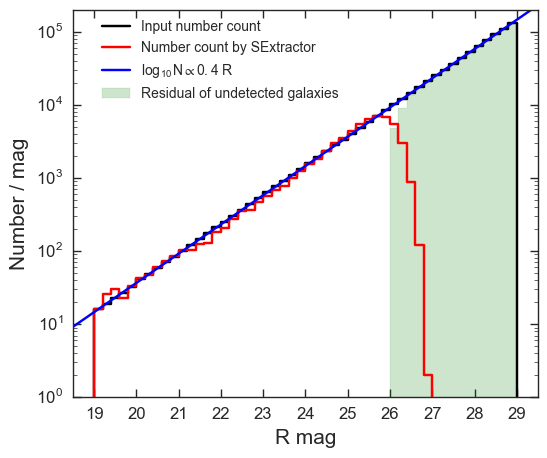

In [32]:


mags = np.array([ float(line.rstrip('\n')) for line \
                in open(All.Path + All.inputmagsfile)])

mag_sex = np.array([float(line.rstrip('\n')) for line \
                in open(All.Path + All.sexdatafile)])


fontsize  = 15
binsize = 0.2
minval = 18.; maxval = 29.
histrange = [minval, maxval]
nbins  = int((maxval - minval)/ binsize)


val = mags
bins, edges = np.histogram(val, nbins,range = histrange)
left, right = edges[:-1],edges[1:]
X0 = np.array([left,right]).T.flatten(); 
Y0 = np.array([bins,bins]).T.flatten() 
Xdata0 = X0[::2] + 0.5 * (X0[1]-X0[0]); Ydata0 = Y0[::2]
X0 = np.concatenate((X0,[29.]))
Y0 = np.concatenate((Y0,[0]))


val = mag_sex
bins, edges = np.histogram(val, nbins,range = histrange)
left, right = edges[:-1],edges[1:]
X1 = np.array([left,right]).T.flatten(); 
Y1 = np.array([bins,bins]).T.flatten()
Xdata1 = X1[::2] + 0.5 * (X1[1]-X1[0]); Ydata1 = Y1[::2]
X1 = np.concatenate((X1,[29.]))
Y1 = np.concatenate((Y1,[0]))


Residual = Y0 - Y1

x = np.linspace(18.5,29.5,100)

plt.figure(0,figsize=(6,5))
plt.plot(X0,Y0,'k-',label = 'Input number count')
plt.plot(X1,Y1,'r-', label = 'Number count by SExtractor')
plt.plot(x,GalNum(x),'b-',label = '$\mathregular{log_{10}N \propto 0.4\ R}$')



plt.fill_between(X0[X0>25.9], Residual[X0>25.9], \
                 np.zeros(len(X0[X0>25.5])),color='green',\
                 alpha = 0.2,label='Residual of undetected galaxies')

plt.xlim(18.5,29.5)
plt.ylim(1,2.e5)
plt.yscale('log')
plt.ylabel('Number / mag',size = fontsize)
plt.xlabel('R mag',size = fontsize)
plt.legend(frameon=False, loc = [0.05,0.75])
plt.tick_params(axis='both', labelsize=fontsize-3)   
plt.xticks([19,20,21,22,23,24,25,26,27,28,29])
plt.show()



Show the number of undetected galaxies in each magnitude bin

In [33]:
Rmaglist = X0[X0>25.7][::2][1:] - 0.1  # 0.1 : to shift R mag to the center of each bin
Ngallist = Residual[X0>25.7][::2][1:]
print 'R mag of undetected galaxies:\n', Rmaglist
print 'The number of undetected galaxies in each mag bin:\n', Ngallist
Rmaglist = np.array(Rmaglist); Ngallist = np.array(Ngallist,dtype='float')

R mag of undetected galaxies:
[ 25.9  26.1  26.3  26.5  26.7  26.9  27.1  27.3  27.5  27.7  27.9  28.1
  28.3  28.5  28.7  28.9]
The number of undetected galaxies in each mag bin:
[  1491   4765   9095  13735  17474  21115  25554  30430  36741  44180
  53080  64187  76422  92257 111001 133692]


Gather all pixel values above 30 mag / arcsec^2 in the entire field.

Then divide the number in each mag bin by (80/8000)^2:
it represents the pixel distribution of undetected galaxies in a 80 x 80 pixel region "w/o any detected galaxies"

We are going to renormalize the number (amplitude) later 

In [38]:
path = All.Path
Modellist = ['mygalR24_avg.fits', 'mygalR25_avg.fits', \
             'mygalR26_avg.fits','mygalR27_avg.fits',\
             'mygalR28_avg.fits','mygalR29_avg.fits']


HistFac  =  (80./8000.)**2.
Ngallist *=  HistFac # normalize amplitdue for a 80 by 80 pixel region

HistUGalsPix0 = []; HistUGalsPix = [];
for i in range(len(Rmaglist)):
    Rmag = int(round(Rmaglist[i]))
    filename = 'mygalR'+str(Rmag)+'_avg.fits'
    hdu = fits.open(path+filename)
    prof0 = hdu[0].data.ravel() 

    Ftot = 10.**((All.m0-Rmaglist[i])/2.5)
    prof0 = prof0 * Ftot
    
    prof0 = prof0[prof0 > 0.81] # Note : 0.81 ADU ~ 30 mag / arcsec^2
    mu = 0.; cnt = 0.
    for j in range(int(Ngallist[i])):
        mu += np.sum(prof0); cnt += len(prof0)
        HistUGalsPix0 += list(prof0)
        
HistUGalsPix0 = np.array(HistUGalsPix0)  

In [39]:
data = np.random.normal(0, scale = 12.73, size = 80**2)

binsize = 3.5 * np.std(data) *  len(data) **(-0.33333333) * 1. 
print binsize # typical binsize of pure gaussian noise in 80 by 80 pixels 
              # but it will change depending on position.

2.39197839397


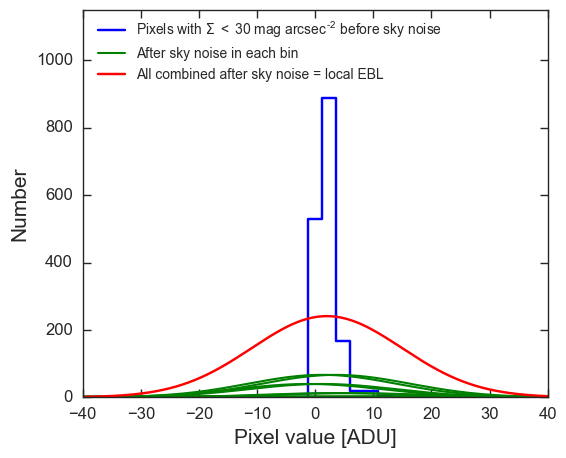

In [40]:
fontsize  = 15

fig = plt.figure(0,figsize = (6,5))


binsize = 2.4

histrange = [0-binsize*0.5, binsize*20+0.5*binsize]

nbins = int((histrange[1] - histrange[0]) / binsize)
bins, edges = np.histogram(HistUGalsPix0, nbins,range = histrange) # 30 mag / arcsec^2
left, right = edges[:-1],edges[1:]
X = np.array([left,right],dtype = 'float').T.flatten(); 
Y = np.array([bins,bins],dtype = 'float').T.flatten();
X = np.concatenate(([X[0]],X))
Y = np.concatenate(([0],Y))
plt.plot(X,Y,'b-', \
        label = 'Pixels with $\mathregular{\Sigma\ <\ 30\ mag\ arcsec^{-2}}$ before sky noise' )
        #label = 'Pixels ($\mathregular{<\ 30\ mag\ arcsec^{-2}}$) before sky noise')


sky   = 0.
noise = 12.73
Nstack  = 20.
x = np.linspace(-50,70,1000)

for i in range(len(X)):
    amp = Y[i] * binsize    
    sig = np.sqrt(noise**2. + X[i]**2. / Nstack)    
    if i == 0:
        y = amp / np.sqrt(2. * np.pi) / sig * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig)
        plt.plot(x,y,'g-',label = 'After sky noise in each bin',linewidth = 1.5)
    else:
        y += amp / np.sqrt(2. * np.pi) / sig * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig)
        plt.plot(x, amp / np.sqrt(2. * np.pi) / sig \
                 * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig),'g-',linewidth = 1.5)

plt.plot(x,y,'r-',label = 'All combined after sky noise = local EBL')

plt.ylabel('Number',size = fontsize)
plt.xlabel('Pixel value [ADU]',size = fontsize)
plt.xlim(-40,40)
plt.ylim(0,1150)

plt.legend(frameon=False, loc = [0.02,0.8])
plt.tick_params(axis='both', labelsize=fontsize-3)   

plt.show()

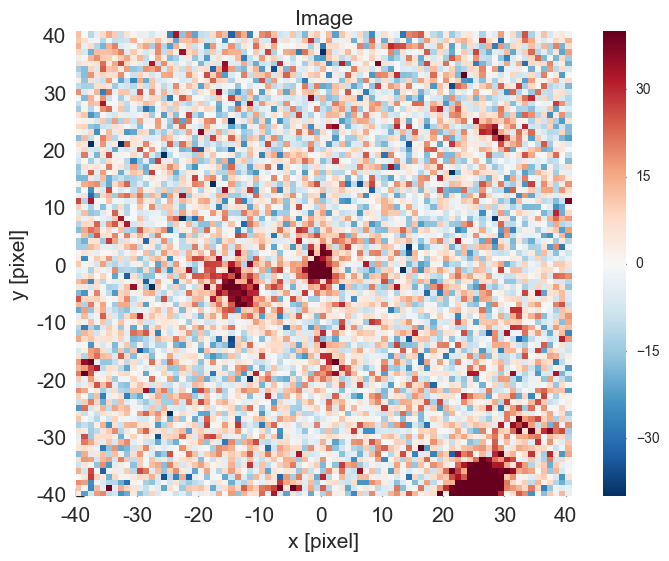

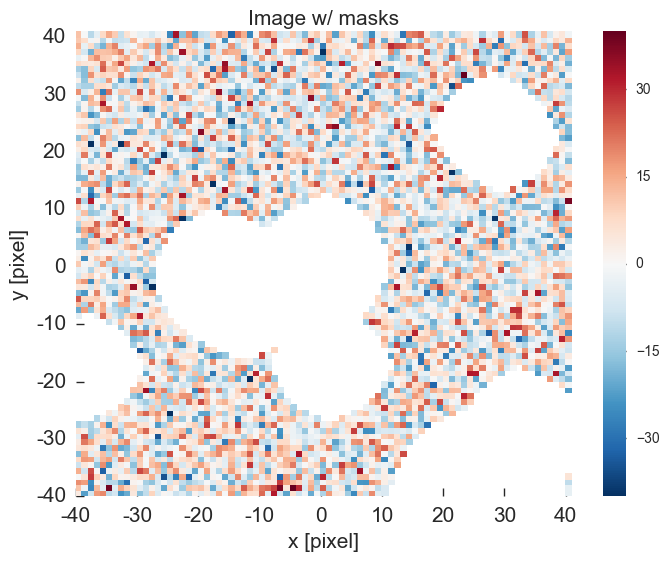

local sky :  0.0365134988492
local sky noise :  12.7121415139
True sky :  0
True sky noise :  12.7279220614


In [41]:

#example

xc = 60; yc = 60; Re = 2.   



dx = dy = int(Re*20.) 
iterate = True 

while iterate:
    x0 = xc - dx; x1 = xc + dx; y0 = yc - dy; y1 = yc + dy;
    if x0 < 0: x0 = 0 ; 
    if x1 > All.MaxPos: x1 = All.MaxPos;
    if y0 < 0: y0 = 0 ; 
    if y1 > All.MaxPos: y1 = All.MaxPos;
    img = Map.Img[y0:y1+1, x0:x1+1].copy()
    seg = Map.Seg[y0:y1+1, x0:x1+1].copy()

    Nmax = np.max(seg.ravel())
    for i in range(1, Nmax+1):
        if np.sum(seg.ravel() == i) == 0: continue
        flux = np.sum(img.ravel()[seg.ravel() == i])
        mag = All.m0 - 2.5*np.log10(flux)
        fac = return_mask_fac(mag) 
        seg = grow_mask(seg, fac, i)

    ind_not	 = np.logical_not(seg == 0) 
    seg[ind_not] = -1
    seg = grow_mask(seg, fac, -1)
    if (np.sum(seg != -1) > 4000) and ((x1 - x0 + 1  > 79) \
        or  (y1 - y0 + 1  > 79)): iterate = False
    else: 
        dx += 5; dy += 5;


Bndry = dx;
vmin = -40; vmax = 40;
extent = (-Bndry, Bndry, -Bndry, Bndry); 

fig = plt.figure(0,figsize = (8,6))
ax = plt.axes()
sns.heatmap(np.rot90(img),vmin = vmin, vmax = vmax, ax = ax)
ax.set_xticks(np.arange(0,90,10))
ax.set_xticklabels(map(str, np.arange(0,90,10)-40), minor=False,rotation=0)
ax.set_yticks(np.arange(0,90,10))
ax.set_yticklabels(map(str, np.arange(0,90,10)-40), minor=False,rotation=0)
ax.set_xlabel('x [pixel]', size = fontsize)
ax.set_ylabel('y [pixel]', size = fontsize)
plt.tick_params(labelsize=fontsize) 
plt.title('Image',size=fontsize) 
plt.show()


ind_not = np.logical_not(seg == 0) 
seg[ind_not] = -1

img[seg != 0] = np.nan

fig = plt.figure(0,figsize = (8,6))
ax = plt.axes()
sns.heatmap(np.rot90(img),vmin = vmin, vmax = vmax, ax = ax)
ax.set_xticks(np.arange(0,90,10))
ax.set_xticklabels(map(str, np.arange(0,90,10)-40), minor=False,rotation=0)
ax.set_yticks(np.arange(0,90,10))
ax.set_yticklabels(map(str, np.arange(0,90,10)-40), minor=False,rotation=0)
ax.set_xlabel('x [pixel]', size = fontsize)
ax.set_ylabel('y [pixel]', size = fontsize)
plt.tick_params(labelsize=fontsize) 
plt.title('Image w/ masks',size=fontsize) 
plt.show()

data = img[np.isfinite(img)].copy().ravel()
mu_SEx, sig_SEx, Crowd =  est_sky_SEx(data.copy())
minval = np.max([mu_SEx - 3. * sig_SEx, -150]);   
binsize =  3.5 * np.std(data) *  len(data) **(-0.33333333) * 1. # Bin size by Scott rule
maxval = mu_SEx + 3.* sig_SEx    
maxval = minval + round((maxval-minval)/binsize) * binsize

bins, edges = np.histogram(data, int((maxval - minval)/binsize),\
                            range = [minval,maxval])
left, right = edges[:-1],edges[1:]
x_hist = np.array([left,right],dtype = 'float').T.flatten(); 
y_hist = np.array([bins,bins], dtype = 'float').T.flatten();    
x = x_hist[::2] + 0.5 * (x_hist[1]-x_hist[0]); y = y_hist[::2];   


bins, edges = np.histogram(HistUGalsPix0, int((maxval - minval)/binsize),\
                           range = [minval,maxval])
left, right = edges[:-1],edges[1:]
x_hist = np.array([left,right],dtype = 'float').T.flatten(); 
y_hist = np.array([bins,bins], dtype = 'float').T.flatten();    
x2 = x_hist[::2] + 0.5 * (x_hist[1]-x_hist[0]); y2 = y_hist[::2];   
amp_ratio = 1. * np.sum(np.isfinite(data)) / (80.)**2. 

param, xsqr, error =  skyfit( x = x, y = y, x2 = x2, y2 = y2, \
                    param = [np.max(y), mu_SEx, sig_SEx,  amp_ratio] )

print 'local sky : ', param[1]
print 'local sky noise : ', param[2]
print 'True sky : ',0
print 'True sky noise : ', np.sqrt(3240./20)

In [42]:
# all steps are included in estimate_sky:
estimate_sky(xc,yc,Re)

(0.03651349884920288, 12.712141513888243)